In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
with open("../Names.txt", 'r') as f:
    names = f.read().split('\n')

In [3]:
len(names)

55692

In [4]:
print(np.unique(list(''.join(names))))

[' ' '-' '.' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O'
 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g'
 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y'
 'z']


In [5]:
stopchars = [" ","-","."]

In [6]:
names = [name.lower() for name in names if not any(char in stopchars for char in name)]

In [7]:
chars = np.unique(['!']+list(''.join(names)))

In [8]:
char_index = dict()
for char in chars:
    char_index[char] = len(char_index)

In [9]:
window_length = 8
Xs,ys = [],[]
for name in names:
    window = [0]*window_length
    for c in name+'!':
        Xs.append(window)
        ys.append(char_index[c])
        window = window[1:]+[char_index[c]]

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
Xs = torch.tensor(Xs, dtype=torch.long, device=device)
ys = torch.tensor(ys, dtype=torch.long, device=device)

In [12]:
for i in range(30):
    print(chars[Xs[i].cpu()], chars[ys[i].cpu()])

['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] a
['!' '!' '!' '!' 'a' 'a' 'b' 'a'] n
['!' '!' '!' 'a' 'a' 'b' 'a' 'n'] !
['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] h
['!' '!' '!' '!' 'a' 'a' 'b' 'h'] a
['!' '!' '!' 'a' 'a' 'b' 'h' 'a'] r
['!' '!' 'a' 'a' 'b' 'h' 'a' 'r'] a
['!' 'a' 'a' 'b' 'h' 'a' 'r' 'a'] n
['a' 'a' 'b' 'h' 'a' 'r' 'a' 'n'] !
['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] h
['!' '!' '!' '!' 'a' 'a' 'b' 'h'] a
['!' '!' '!' 'a' 'a' 'b' 'h' 'a'] s
['!' '!' 'a' 'a' 'b' 'h' 'a' 's'] !
['!' '!' '!' '!' '!' '!' '!' '!'] a
['!' '!' '!' '!' '!' '!' '!' 'a'] a
['!' '!' '!' '!' '!' '!' 'a' 'a'] b
['!' '!' '!' '!' '!' 'a' 'a' 'b'] h
['!' '!' '!' '!' 'a' 'a' 'b' 'h'] a
['!' '!' '!' 'a' 'a' 'b' 'h'

In [13]:
Xs.shape, Xs.dtype, ys.shape, ys.dtype

(torch.Size([494648, 8]), torch.int64, torch.Size([494648]), torch.int64)

In [29]:
embedding_dim = 15
hidden_layer = 100
l = window_length*embedding_dim
C = torch.randn((len(chars), embedding_dim), requires_grad=True, device=device)
W1 = torch.randn((l,hidden_layer), device=device)
b1 = torch.randn((hidden_layer), device=device)
W2 = torch.randn(hidden_layer,len(chars), device=device)
b2 = torch.randn(len(chars), device=device)
bnbias = torch.ones((1,hidden_layer), device=device)
bngain = torch.zeros((hidden_layer), device=device)
bnmean_running = torch.zeros((1,hidden_layer), device=device)
bnstd_running = torch.ones((1,hidden_layer), device=device)
parameters = [W1,b1,W2,b2,C,bngain,bnbias]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

15432


In [30]:
lre = np.linspace(-3,0,1000)
lrs = 10**lre

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=42)
X_train,X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [32]:
batch_size=32
exp_rates = []
losses = []
for i in range(1000):
    #minibatch
    batch = torch.randint(0,len(X_train), (batch_size,))
    x_batch=X_train[batch]
    y_batch=y_train[batch]
    # forward pass
    emb = C[x_batch]
    embcat = emb.reshape(-1,l)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = (hpreact-bnmeani)/bnstdi                                      #batchnorm
    hpreact = bngain * hpreact + bnbias                                     #batchnorm
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_batch)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= lrs[i] * p.grad
    losses.append(loss.item())
    exp_rates.append(lre[i])

In [33]:
loss.item()

7.73175573348999

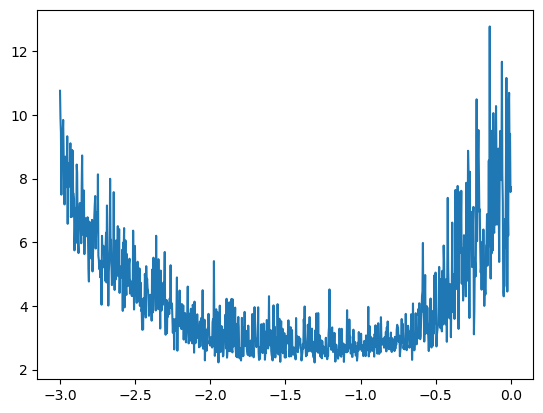

In [34]:
plt.plot(exp_rates,losses)

In [35]:
#10**-1 = 0.1 seems to be the right learning rate
batch_size=32
losses = []
epochs = 200000
for i in range(epochs):
    #minibatch
    batch = torch.randint(0,len(X_train), (batch_size,))
    x_batch=X_train[batch]
    y_batch=y_train[batch]
    # forward pass
    emb = C[x_batch]
    embcat = emb.reshape(-1,l)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)         #batchnorm
    bnstdi = hpreact.std(0, keepdim=True)           #batchnorm
    hpreact = (hpreact-bnmeani)/bnstdi
    hpreact = bngain * hpreact + bnbias
    with torch.inference_mode():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_batch)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    # print(loss.item())
    # losses.append(loss.item())

In [38]:
with torch.inference_mode():
    emb = C[X_train]
    hpreact = emb.reshape(-1,l) @ W1 + b1
    hpreact = (hpreact-bnmean_running)/bnstd_running
    hpreact = bngain * hpreact + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, y_train)
    emb = C[X_val]
    hpreact = emb.reshape(-1,l) @ W1 + b1
    hpreact = (hpreact-bnmean_running)/bnstd_running
    hpreact = bngain * hpreact + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    val_loss = F.cross_entropy(logits, y_val)
    print(f'Train loss: {train_loss.item()}, Val loss: {val_loss.item()}')

Train loss: 1.972307801246643, Val loss: 1.9823341369628906


In [42]:
import pickle
torch.save(C, 'params/C.pt')
torch.save(W1, 'params/W1.pt')
torch.save(b1, 'params/b1.pt')
torch.save(W2, 'params/W2.pt')
torch.save(b2, 'params/b2.pt')
torch.save(bngain, 'params/bngain.pt')
torch.save(bnbias, 'params/bnbias.pt')
torch.save(bnmean_running, 'params/bnmean.pt')
torch.save(bnstd_running, 'params/bnstd.pt')
with open('params/chars.pkl', 'wb') as f:
    pickle.dump(chars, f)
with open('params/char_index.pkl', 'wb') as f:
    pickle.dump(char_index, f)